In [2]:
library(tidyverse)
library("ggplot2")
library("patchwork")
library(dplyr)
library(tibble)
library(cowplot)
library(datateachr)
library(infer)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




# Number of Fires by Cause Class in Canada (1990-2020)
By: Brendan Yuen, Daniel Ma, Jiayi Zou, Elmeri Hakkinen

# Introduction

Forest fires are a significant environmental concern in Canada due to the country's vast forested areas and diverse climatic conditions. These fires can have severe ecological, economic, and social impacts on the affected regions (Coogan et al. 2021). Understanding the causes and patterns of forest fires is essential for developing effective strategies for prevention, mitigation, and response.


About the dataset:\
This dataset from Canada's National Foresty Database contains information on the number of forest fires by cause that occurred in various jurisdictions (administrative regions) across Canada from 1990 to 2021, in English and French. The variables are:
* `Year / Année`: This column represents the year when the forest fire incidents occurred. The years range from 1990-2021.
* `ISO`: This column contains the ISO code corresponding to the specific geographic region or province where each fire incident took place.
* `Jurisdiction / Juridiction`: This column indicates the administrative region or jurisdiction responsible for the area where the fire incident occurred.
* `Cause / Origine`: This column categorizes the primary reason behind each fire incident. The causes include Human activity, Lightning, Prescribed burn, Reburn and Unspecified.
* `Number / Nombre`: This column represents the numerical count of fire incidents recorded for each specific combination of year, ISO code, and cause.
* `Data Qualifier / Qualificatifs de données`: Data Qualifier: An indicator of data quality or reliability, specifying if the data is provisional, confirmed, or estimated.

The data could be used for various analyses, such as identifying trends in fire incidents, understanding the impact of different causes, and formulating effective fire management and prevention strategies. This raises the question, did the proportion of fires cause by humans increase over time; have humans become more wreckless or are there underlying environmental issues? To answer this question we will be analyzing the proportion and standard deviation of fires caused by humans.

# Methods and Results

## Preliminary Results 

Import the data from csv and added a seed to make code reproducible

In [3]:
set.seed(999)
fire_data <- read_csv("https://raw.githubusercontent.com/hakkd/stat-201-group-2/main/fire_data.csv")

head(fire_data)

Rows: 1059 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): ISO, Jurisdiction, Juridiction, Cause, Origine, Data Qualifier, Qua...
dbl (4): Year, AnnÈe, Number, Nombre

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year,AnnÈe,ISO,Jurisdiction,Juridiction,Cause,Origine,Number,Data Qualifier,Nombre,Qualificatifs de donnÈes
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1990,1990,AB,Alberta,Alberta,Human activity,ActivitÈs humaines,379,a,379,a
1990,1990,AB,Alberta,Alberta,Lightning,Foudre,971,a,971,a
1990,1990,AB,Alberta,Alberta,Unspecified,IndÈterminÈe,16,a,16,a
1990,1990,BC,British Columbia,Colombie-Britannique,Human activity,ActivitÈs humaines,1240,a,1240,a
1990,1990,BC,British Columbia,Colombie-Britannique,Lightning,Foudre,2015,a,2015,a
1990,1990,MB,Manitoba,Manitoba,Human activity,ActivitÈs humaines,283,a,283,a


The data table has 11 columns, with duplicate columns in English and French. 

We will drop the French columns as well as the Data Qualifier column for simplicity.

In [4]:
fire_data <- fire_data %>% 
    select(Year, ISO, Jurisdiction, Cause, Number)

head(fire_data)

Year,ISO,Jurisdiction,Cause,Number
<dbl>,<chr>,<chr>,<chr>,<dbl>
1990,AB,Alberta,Human activity,379
1990,AB,Alberta,Lightning,971
1990,AB,Alberta,Unspecified,16
1990,BC,British Columbia,Human activity,1240
1990,BC,British Columbia,Lightning,2015
1990,MB,Manitoba,Human activity,283


We can use the `summary()` function to get summary statistics for all of the columns.

In [5]:
summary(fire_data)

      Year          ISO            Jurisdiction          Cause          
 Min.   :1990   Length:1059        Length:1059        Length:1059       
 1st Qu.:1998   Class :character   Class :character   Class :character  
 Median :2007   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2006                                                           
 3rd Qu.:2014                                                           
 Max.   :2021                                                           
                                                                        
     Number      
 Min.   :   0.0  
 1st Qu.:   8.0  
 Median :  63.0  
 Mean   : 217.5  
 3rd Qu.: 292.2  
 Max.   :2888.0  
 NA's   :9       

We can see that there are 9 NAs in the Number column. Rows containing NA can be dropped. We will then plot the data to visualize any general trends in number of fires by cause over time. We will also drop data for the year 2021 because those fires have no specific cause attributed to them.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



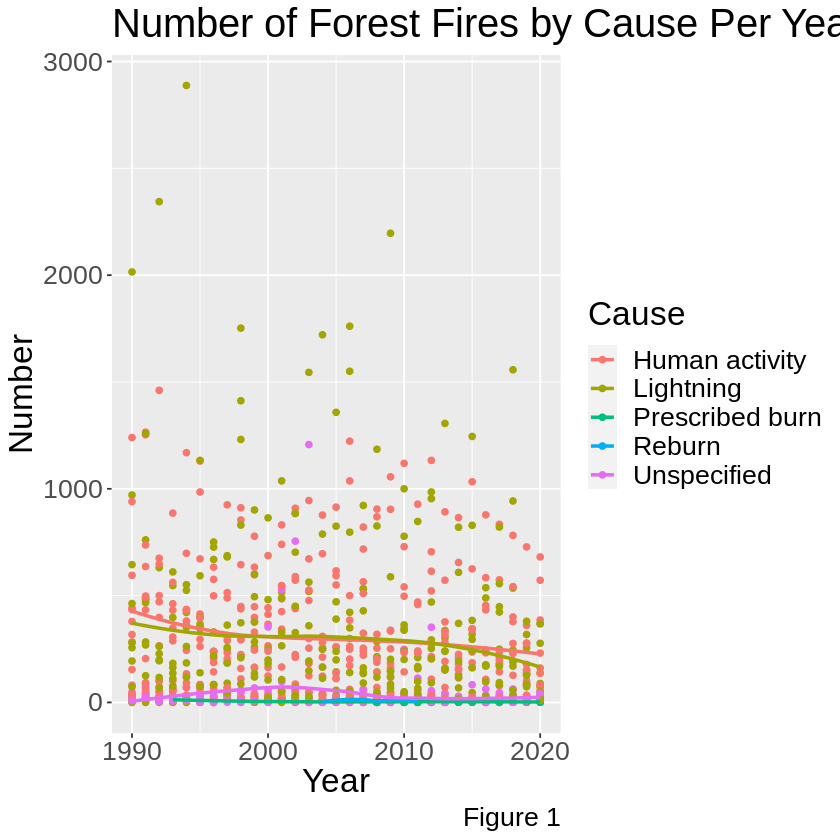

In [6]:
fire_data <- fire_data %>% 
    drop_na(Number) %>%
    filter(Year < 2021)

fire_plot <- fire_data %>%
    ggplot(aes(x = Year, y = Number, color = Cause)) + 
    geom_point() + 
    geom_smooth(se = FALSE) +
    theme(text = element_text(size = 20)) +
    ggtitle("Number of Forest Fires by Cause Per Year in Canada") +
    labs(caption = "Figure 1")

fire_plot

The plot above shows that human activity and lightning have been responsible for the most forest fires during the past 30 years. 

Next we'll compute the sample proportion and standard error for the two group of interest (1990-2005 and 2006-2020) and a point estimate for the difference in proportions.

In [31]:
fire_data_grouped <- fire_data %>%
    mutate(group = case_when(Year <= 2005 ~ "1990 - 2005", Year > 2005 ~ "2006 - 2020")) %>%
    group_by(group) %>%
    summarise(
        n = sum(Number),
        p_hat = sum(Number[Cause == "Human activity"])/n,
        se = sqrt(p_hat * (1-p_hat) / n)
    )

head(fire_data_grouped)

year_split <- fire_data %>%
    group_by(Year) %>%
    summarise(
        n = sum(Number),
        p_hat = sum(Number[Cause == "Human activity"])/n,
        se = sqrt(p_hat * (1-p_hat) / n))


paste("Correlation of proportion of human caused fires and year is:", cor(year_split$Year, year_split$p_hat))

group,n,p_hat,se
<chr>,<dbl>,<dbl>,<dbl>
1990 - 2005,127428,0.4965942,0.001400643
2006 - 2020,94378,0.5103626,0.001627201


[1] "Correlation of proportion of human caused fires and year is: 0.176331686448167"

As we can see from the correlation of the year and the proportion of human caused fires, there is a possitive association between the two variables.

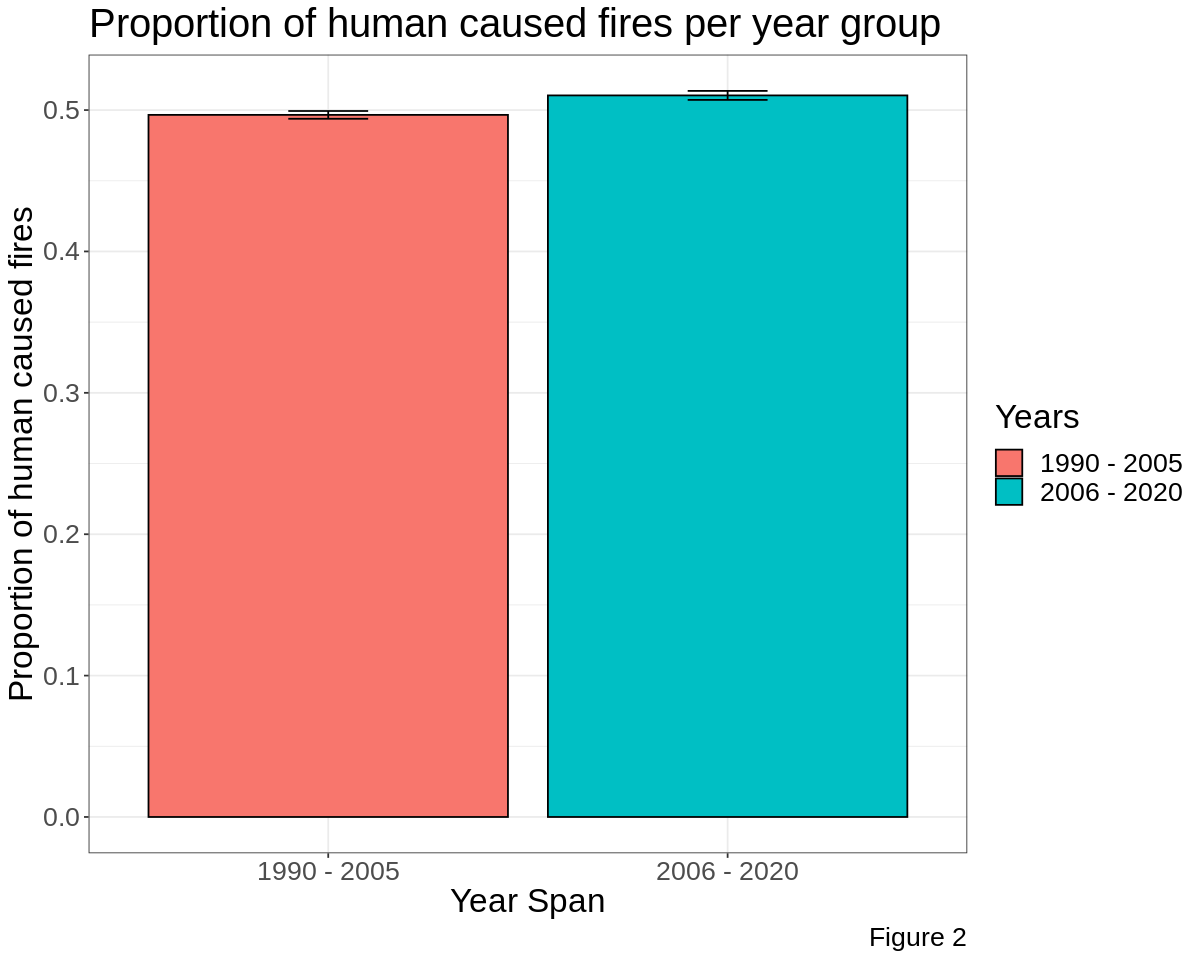

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)

year_span_barplot <- fire_data_grouped %>%
    ggplot(aes(x = group, y = p_hat, fill = group)) + 
    geom_bar(stat="identity", color="black", 
           position=position_dodge()) +
    geom_errorbar(aes(ymin=p_hat-(qnorm(0.975) * se), ymax=p_hat+(qnorm(0.975) * se)), width=.2,
                 position=position_dodge(.9)) +
    theme_bw() +
    theme(text = element_text(size = 20)) +
    ggtitle("Proportion of human caused fires per year group") + 
    xlab("Year Span") + 
    ylab("Proportion of human caused fires") +
    labs(fill = "Years",
        caption = "Figure 2")

year_span_barplot

The summary table and boxplots above show that approximately half of all fires during the last 30 years have been caused by humans and the difference in proportions of human-caused fires is close to zero, suggesting that there may not be a difference in the two proportions. 

While the plots and estimates derived from the data provide valuable insights into the wildfire characteristics and trends, they may not be sufficient analysis for informed decision-making. Plots and estimates alone do not provide statistical evidence to support any significant differences or trends observed in the data. Stakeholders more robust evidence, such as hypothesis tests and confidence intervals, to understand the reliability of the findings.

To address the gap and provide more reliable conclusions, additional analyses are essential. Two statistical tools, namely hypothesis testing and confidence intervals, will be employed to enhance the significance and credibility of the results.

## Comparing the Proportions of Independent Populations: A two-sample z-test

**Hypothesis Testing**: We will perform a two-sample z-test hypothesis test (theory based method) and the bootstraping method, with a significance level α = 0.05, to investigate whether there is a significant difference in the proportion and standard deviation of human-caused fires between two time spans. We chose a significance level of 0.05, such that there is a 5% chance that we find a difference in the proportion of human caused fires between two time spans, when in fact there is no difference. A consequence of commiting type I error in our investigation could be that human activity in nature is unnecessarily restricted.

* Null Hypothesis (H0): **p1 - p2 = 0**
  * There is no significant difference in the proportion of fires, caused by human activity, between the selected years, where p1 are the proportion values from 1990 – 2005 and p2 are proportion values from 2006 – 2020. 

* Alternative Hypothesis (Ha): **p1 - p2 ≠ 0**
   * There is a significant difference in the proportion of fires, caused by human activity, between the selected years. 
   
**TODO** do we have a histogram for this? ->
Since the distribution is not Normally distributed, we have to rely on the CLT.

## Check Conditions

Given that our samples are large we predict that the null model of the test statistic will be Normal.

Check conditions:
np ≥ 10 and n(1-p) ≥ 10

In [9]:
# n1p <- fire_data_grouped$n[1]*fire_data_grouped$p_hat[1] >= 10

paste("n1 * p1 ≥ 10: ", fire_data_grouped$n[1]*fire_data_grouped$p_hat[1] >= 10)
paste("n2 * p2 ≥ 10: ", fire_data_grouped$n[2]*fire_data_grouped$p_hat[2] >= 10)
paste("n1(1 - p1) ≥ 10: ", fire_data_grouped$n[1]*(1-fire_data_grouped$p_hat[1]) >= 10)
paste("n2(1 - p2) ≥ 10: ",fire_data_grouped$n[2]*(1-fire_data_grouped$p_hat[2]) >= 10)

[1] "n1 * p1 ≥ 10:  TRUE"

[1] "n2 * p2 ≥ 10:  TRUE"

[1] "n1(1 - p1) ≥ 10:  TRUE"

[1] "n2(1 - p2) ≥ 10:  TRUE"

Since the both samples are large enough the approximation of the null-model being normal is good.

## Calculating Point estimate and Observed Test Statistic

Next, let's calculate our point estimate and test statistics given these formulas:

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$

$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$ 



In [10]:
point_estimate <- (fire_data_grouped$n[1]*fire_data_grouped$p_hat[1] + fire_data_grouped$n[2] * fire_data_grouped$p_hat[2])/
                  (fire_data_grouped$n[1] + fire_data_grouped$n[2])
paste("The point estimate is:", point_estimate)

test_stat <- (fire_data_grouped$p_hat[1] - fire_data_grouped$p_hat[2]) /
            sqrt(point_estimate * (1 - point_estimate) * (1/fire_data_grouped$n[1] + 1/fire_data_grouped$n[2])) 
paste("The test statistic is:", test_stat)

[1] "The point estimate is: 0.502452593708015"

[1] "The test statistic is: -6.4121075019213"

Now given the calculated test statistics, we can now calculate the p value.

In [11]:
p_value <- 2 * pnorm(test_stat)
paste("p value is:", p_value)

[1] "p value is: 1.43521569619257e-10"

Given a significance level of 5%, we reject the null hypothesis the there is no significant difference in the proportion of fires, caused by human activity, between the years 1990 - 2005 and 2006 - 2020.

## Bootstrapping Method

To create a bootstrapping distribution we need to alter the original data

First, we need to change the `fire_data`'s `Number` column as an individual data point instead of the total fire events for the year. 

In [12]:

expanded_data <- data.frame()
for (i in 1:nrow(fire_data)) {
  num_fires <- fire_data$Number[i]
  repeated_rows <- data.frame(Cause = rep(fire_data$Cause[i], num_fires))
  repeated_rows_year <- data.frame(Year = rep(fire_data$Year[i], num_fires))
  expanded_data <- rbind(expanded_data, c(repeated_rows_year, repeated_rows))
}
expanded_data_1990_2005 <- expanded_data |>
                           filter(Year <= 2005)
expanded_data_2006_2020 <- expanded_data |>
                           filter(Year >= 2006, Year <= 2020)

summary(expanded_data_1990_2005)
summary(expanded_data_2006_2020)
expanded_data_all <- expanded_data |>
                     mutate(Year = case_when(Year <= 2005 ~ "1990 - 2005", Year > 2005 ~ "2006 - 2020"),
                           Cause = case_when(Cause != "Human activity" ~ "Not Human Activity", Cause == "Human activity" ~ "Human activity"))

      Year         Cause          
 Min.   :1990   Length:127428     
 1st Qu.:1993   Class :character  
 Median :1997   Mode  :character  
 Mean   :1997                     
 3rd Qu.:2001                     
 Max.   :2005                     

      Year         Cause          
 Min.   :2006   Length:94378      
 1st Qu.:2009   Class :character  
 Median :2012   Mode  :character  
 Mean   :2012                     
 3rd Qu.:2016                     
 Max.   :2020                     

This code extends the rows to allow us to make a randomized bootstrap distribution. 

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


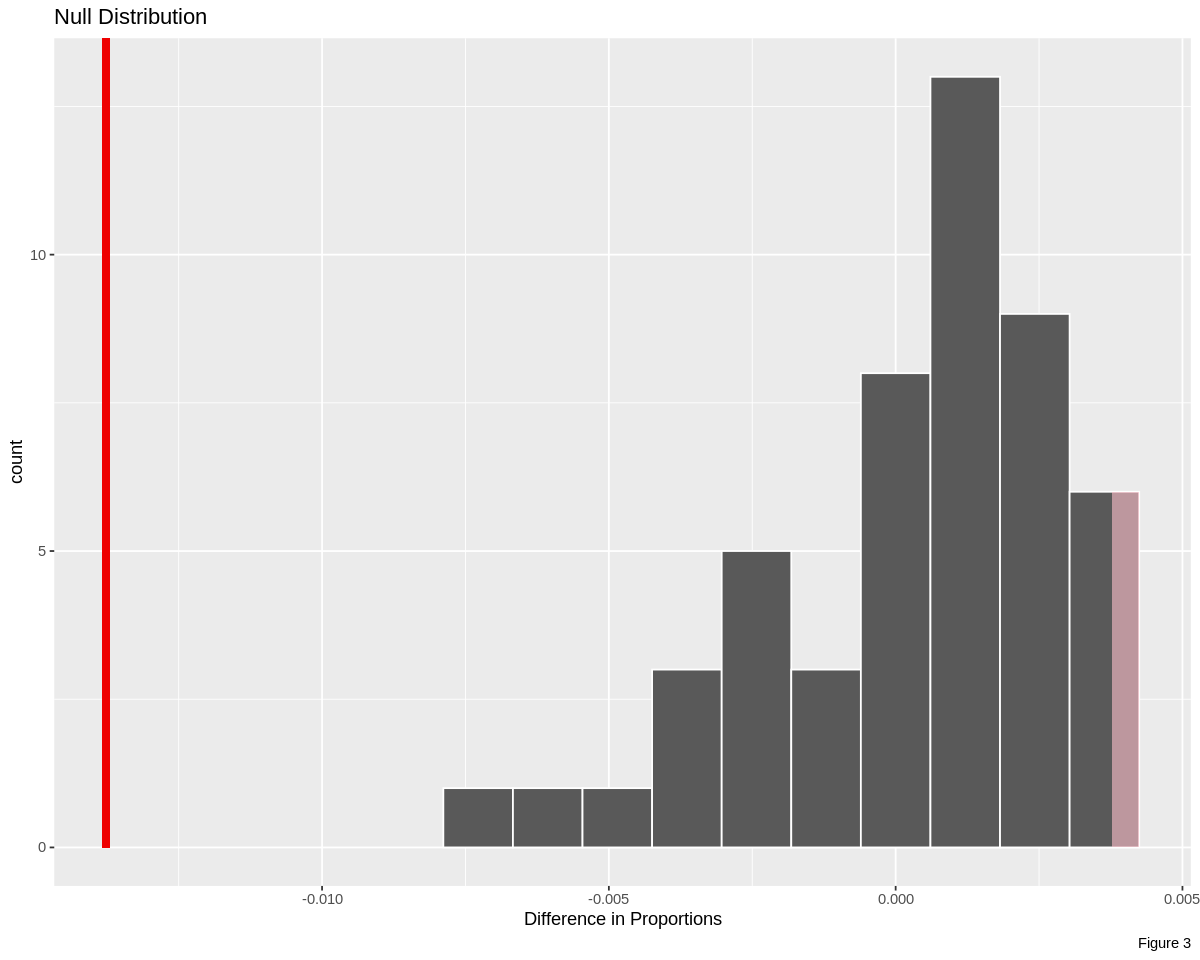

In [17]:
obs_diff_prop <- expanded_data_all |>
                 specify(formula = Cause ~ Year, success = "Human activity") |>
                 calculate(stat = "diff in props", order = c("1990 - 2005", "2006 - 2020"))

null_distribution_fire <- 
     expanded_data_all %>% 
     specify(formula = Cause ~ Year, success = "Human activity") %>% 
     hypothesize(null = "independence") %>% 
     generate(type = "permute", reps = 50) %>% 
     calculate(stat = "diff in props", order = c("1990 - 2005", "2006 - 2020"))


fire_result_plot <- visualize(null_distribution_fire, bins = 10) +
                         shade_p_value(obs_stat = obs_diff_prop, direction = "both") +
                         labs(x = "Difference in Proportions", caption = "Figure 3") +
                         ggtitle("Null Distribution")
fire_result_plot

p_value <- null_distribution_fire |>
             get_p_value(obs_stat = obs_diff_prop, direction = "both")
p_value

We shouldn't conclude that the p-value is zero because it means that there is no chance of type I error, so we conclude that the p value is less than 0.01. Therefore from our hypothesis test, we conclude that given a 5% significance level, we reject the null hypothesis that there is no significant difference in the proportion of fires, caused by human activity, between the years 1990 - 2005 and 2006 - 2020.

## Confidence Intervals

**Confidence Intervals**: 95% confidence intervals will be calculated for differences in proportions over time. These intervals will provide a range of plausible values for the population parameter and offer insights into the precision and reliability of the estimates.

[1] "The lower bound of the 95% confidence interval for the difference in proportions is  -0.0171941267747608"

[1] "The upper bound of the 95% confidence interval for the difference in proportions is  -0.00976554139923312"

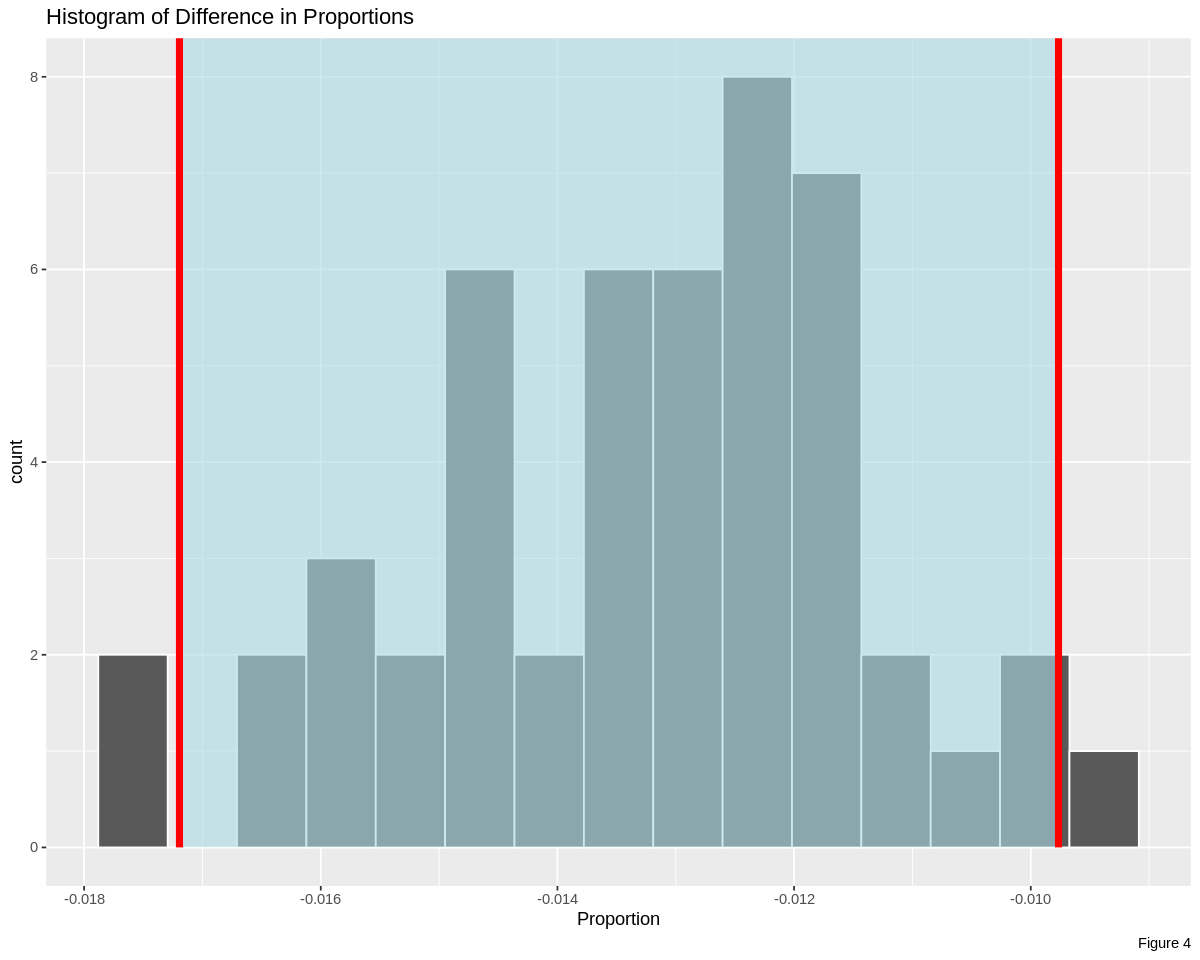

In [16]:
bootstrap_fire <- 
     expanded_data_all %>% 
     specify(formula = Cause ~ Year, success = "Human activity") %>%
     generate(type = "bootstrap", reps = 50) %>% 
     calculate(stat = "diff in props", order = c("1990 - 2005", "2006 - 2020"))

ci <- bootstrap_fire %>% 
      get_confidence_interval(level = 0.95, type = "percentile")
      

paste("The lower bound of the 95% confidence interval for the difference in proportions is ", ci$lower_ci)
paste("The upper bound of the 95% confidence interval for the difference in proportions is ", ci$upper_ci)

visualize(bootstrap_fire) +
shade_ci(endpoints = ci, color = "red", fill = "lightblue") + 
labs(x = "Proportion", caption = "Figure 4") +
ggtitle("Histogram of Difference in Proportions")

The 95% confidence interval is quite small and centred around zero. This suggests that the true difference in proportions is close to zero. We are 95% confident that a 95% confidence interval of (-0.0171501185658078, -0.00976554139923312) captures the
value of the population parameter.

As we have a large sample size (thousands of data points) our results using asymptotics and bootstrapping are quite similar. In both cases we found a p-value less than 0.01, suggesting that there is enough evidence to reject our null hypothesis that the difference in proportions is zero.

# Discussion 

Through our investigation of the difference in proportions of human-caused fires in Canada between the two time spans 1990-2005 and 2006-2020 we found that there was a significant difference in the proportions. By both the two sample Z-test and the bootstrapping approximation of the null distribution we found a p-value of <0.01. With this result we reject the null hypothesis that there was no difference in the proportion of fires caused by humans during the two time spans. This finding demonstrates that there was a change in the proportion of fires caused by humans between the time spans of 1990-2005 and 2006-2020. These results were in line with our expectation that the hypothesis test and confidence intervals would provide statistically significant evidence of differences in the proportion of forest fires caused by humans between time spans and that the results would reveal variations in fire occurrence and cause over time.
Understanding these changes in wildfire causes can aid in the development of targeted strategies for wildfire prevention, fire risk assessment, and the implementation of effective measures to protect communities and ecosystems.

**Future Questions**

The results of this study may raise further research questions and avenues for exploration. For instance, understanding the factors contributing to the observed changes in fire causes could lead to investigations into climate patterns, land-use changes, or fire management practices. Additionally, the impact of wildfires on biodiversity, air quality, and human health could be areas for future research, aiming to develop more comprehensive wildfire management strategies.

# References

* Forest Fires | National Forestry Database. (n.d.). Retrieved from nfdp.ccfm.org website: http://nfdp.ccfm.org/en/data/fires.php 

**References**
* Coogan, S. C. P., Daniels, L. D., Boychuk, D., Burton, P. J., Flannigan, M. D., Gauthier, S., … Wotton, B. M. (2021). Fifty years of wildland fire science in Canada. Canadian Journal of Forest Research, 51(2), 283–302. https://doi.org/10.1139/cjfr-2020-0314 
* Owens, B. (2023). Why are the Canadian wildfires so bad this year? Nature, 618. https://doi.org/10.1038/d41586-023-01902-4